# Capstone 2024 - Table Recognition Work

Dataset:
[PubTables-1m](https://huggingface.co/datasets/bsmock/pubtables-1m)

Model: 
[YoloV11](https://docs.ultralytics.com/models/yolo11/)

In [1]:
!wget https://huggingface.co/datasets/bsmock/pubtables-1m/resolve/main/PubTables-1M-Structure_Annotations_Val.tar.gz
!wget https://huggingface.co/datasets/bsmock/pubtables-1m/resolve/main/PubTables-1M-Structure_Images_Val.tar.gz

--2024-12-01 17:41:15--  https://huggingface.co/datasets/bsmock/pubtables-1m/resolve/main/PubTables-1M-Structure_Annotations_Val.tar.gz
Resolving huggingface.co (huggingface.co)... 18.173.249.21, 18.173.249.105, 18.173.249.90, ...
Connecting to huggingface.co (huggingface.co)|18.173.249.21|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/36/c0/36c021133128a16f57db86f4cb105c85b76fb8fb4968b96642a02b5140872630/6b8c4b512e24e1040fa0829935ab9c2d13fc0015f7315cc8f13ef82a8bc95ca4?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27PubTables-1M-Structure_Annotations_Val.tar.gz%3B+filename%3D%22PubTables-1M-Structure_Annotations_Val.tar.gz%22%3B&response-content-type=application%2Fgzip&Expires=1733334075&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczMzMzNDA3NX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy8zNi9jMC8zNmMwMjExMzMxMjhhMTZmNTdkYjg2ZjRjYjEwNWM4NWI3NmZiOGZiNDk2OGI5Nj

In [2]:
!mkdir ./data
!mkdir ./data/PubTables-1M-Structure_Images_Val
!mkdir ./data/PubTables-1M-Structure_Annotations_Val
!tar -xf PubTables-1M-Structure_Images_Val.tar.gz -C ./data/PubTables-1M-Structure_Images_Val
!tar -xf PubTables-1M-Structure_Annotations_Val.tar.gz -C ./data/PubTables-1M-Structure_Annotations_Val

# Create YOLO Dataset

In [3]:
import os
import yaml
import shutil
import cv2
import random
import colorsys
import numpy as np

import xml.etree.ElementTree as ET

from glob import glob
from PIL import Image

import matplotlib.pyplot as plt

In [4]:
classes = [
#     'table column',
    'table row',
#     'table spanning cell',
#     'table text cell'
]

def convert_coordinates(size, box):
    dw, dh = 1.0/size[0], 1.0/size[1]
    xmin, ymin, xmax, ymax = box
    w, h = xmax - xmin, ymax - ymin
    x_center, y_center = xmin + w/2, ymin + h/2
    return (x_center * dw, y_center * dh, w * dw, h * dh)

def convert_xml_to_yolo_and_copy_image(xml_file_path, dest_labels_dir, source_images_dir, dest_images_dir):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    filename = root.find('filename').text
    image_path = os.path.join(source_images_dir, filename)
#     print(image_path)
    # Read image dimensions using PIL
    with Image.open(image_path) as img:
        width, height = img.size

    output_filename = os.path.splitext(filename)[0] + '.txt'
    with open(os.path.join(dest_labels_dir, output_filename), 'w') as out_file:
        for obj in root.iter('object'):
            cls = obj.find('name').text
            if cls not in classes:
                continue

            cls_id = classes.index(cls)

            xmlbox = obj.find('bndbox')
            xmin = float(xmlbox.find('xmin').text) / width
            ymin = float(xmlbox.find('ymin').text) / height
            xmax = float(xmlbox.find('xmax').text) / width
            ymax = float(xmlbox.find('ymax').text) / height
            
            # Create a polygon with 4 points (rectangle corners)
            points = [
                (xmin, ymin),  # Top-left
                (xmax, ymin),  # Top-right
                (xmax, ymax),  # Bottom-right
                (xmin, ymax)   # Bottom-left
            ]
            
            # Format the points as a string
            points_str = ' '.join([f'{x:.6f} {y:.6f}' for x, y in points])
            
            out_file.write(f"{cls_id} {points_str}\n")
    
    # Copy corresponding image to train directory
    base_name = os.path.splitext(os.path.basename(xml_file_path))[0]
    for ext in ['.jpg', '.jpeg', '.png', '.bmp']:
        image_file = os.path.join(data_images_dir, base_name + ext)
        if os.path.exists(image_file):
#             print("Copied", image_file, dest_images_dir)
            shutil.copy(image_file, dest_images_dir)
            break
    return

In [5]:
def create_dataset(
    data_images_dir, data_labels_dir, 
    train_images_dir, train_labels_dir,
    val_images_dir, val_labels_dir,
    number_of_samples=0, dataset_split_ratio = 0.8):

    xml_files = glob(os.path.join(data_labels_dir, '*.xml'))

    if number_of_samples:
        xml_files = xml_files[:number_of_samples]
    # Calculate the split index
    split_index = int(len(xml_files) * 0.8)  # Assuming 80% train, 20% val split

    # Split the files
    train_xml_files = xml_files[:split_index]
    val_xml_files = xml_files[split_index:]

    # Process train files
    for xml_file_path in train_xml_files:
        convert_xml_to_yolo_and_copy_image(xml_file_path, train_labels_dir, data_images_dir, train_images_dir)

    # Process validation files
    for xml_file_path in val_xml_files:
        convert_xml_to_yolo_and_copy_image(xml_file_path, val_labels_dir, data_images_dir, val_images_dir)

def create_dataset_yaml(dataset_dir, yaml_path):
  # Create the dataset structure
  dataset = {
      'path': os.path.abspath(dataset_dir),
      'train': 'train',  # Assuming all data is for training
      'val': 'val',    # Using same data for validation
    #   'test': 'train',   # Using same data for testing
      'names': {i: name for i, name in enumerate(classes)},
      'nc': len(classes)
  }

  # Write the YAML file
  with open(yaml_path, 'w') as file:
      yaml.dump(dataset, file, default_flow_style=False)

  print(f"Dataset YAML file created at: {yaml_path}")

In [6]:
data_dir = "/kaggle/working/data"
data_images_dir = "/kaggle/working/data/PubTables-1M-Structure_Images_Val"
data_labels_dir = "/kaggle/working/data/PubTables-1M-Structure_Annotations_Val"

dataset_dir = "/kaggle/working/dataset"
train_images_dir = os.path.join(dataset_dir, "train", "images")
train_labels_dir = os.path.join(dataset_dir, "train", "labels")
val_images_dir = os.path.join(dataset_dir, "val", "images")
val_labels_dir = os.path.join(dataset_dir, "val", "labels")

dataset_yaml_path = "/kaggle/working/dataset/dataset.yaml"

os.makedirs(dataset_dir, exist_ok=True)
os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(train_labels_dir, exist_ok=True)
os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(val_labels_dir, exist_ok=True)

number_of_samples = 5000
dataset_split_ratio = 0.8

create_dataset(
    data_images_dir, data_labels_dir, 
    train_images_dir, train_labels_dir,
    val_images_dir, val_labels_dir,
    number_of_samples,
    dataset_split_ratio
)
create_dataset_yaml(dataset_dir, dataset_yaml_path)

Dataset YAML file created at: /kaggle/working/dataset/dataset.yaml


In [7]:
# !rm -rf "/kaggle/working/dataset"

# Data sample visualization

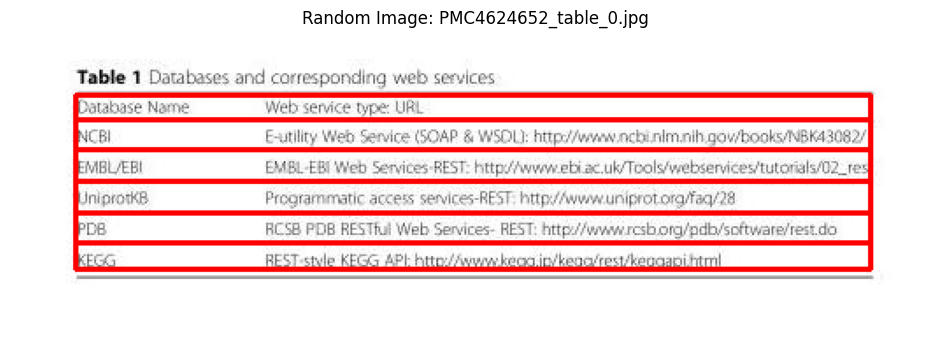

In [8]:
# Load the dataset configuration
with open(dataset_yaml_path, 'r') as file:
    dataset_config = yaml.safe_load(file)

# Get the dataset path and class names
dataset_path = dataset_config['path']
class_names = dataset_config['names']

# Choose a random set (train or val)
image_set = random.choice(['train', 'val'])
images_path = os.path.join(dataset_path, image_set, 'images')
# Get a list of all image files
image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Choose a random image
random_image = random.choice(image_files)
image_path = os.path.join(images_path, random_image)

# Load the image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Load the corresponding label file
label_path = os.path.join(dataset_path, image_set, 'labels', random_image.rsplit('.', 1)[0] + '.txt')

# Read and parse the label file
with open(label_path, 'r') as file:
    labels = file.readlines()

# Get image dimensions
height, width, _ = image.shape

# Function to generate distinct colors
def generate_colors(n):
    hsv_tuples = [(x / n, 1., 1.) for x in range(n)]
    return list(map(lambda x: tuple(round(i * 255) for i in colorsys.hsv_to_rgb(*x)), hsv_tuples))

# Generate a color for each class
colors = generate_colors(len(class_names))

# Draw bounding boxes and labels
for label in labels:
    class_id, *points = map(float, label.strip().split())
    
    # Convert normalized coordinates to pixel coordinates
    pixel_points = [(int(x * width), int(y * height)) for x, y in zip(points[::2], points[1::2])]
    
    # Get color for this class
    color = colors[int(class_id)]
    
    # Draw polygon
    cv2.polylines(image, [np.array(pixel_points)], isClosed=True, color=color, thickness=2)

    # Add label
    class_name = class_names[int(class_id)]
    # cv2.putText(image, class_name, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

# Display the image
plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.axis('off')
plt.title(f"Random Image: {random_image}")
plt.show()

In [9]:
labels

['0 0.070216 0.211857 0.926113 0.211857 0.926113 0.291740 0.070216 0.291740\n',
 '0 0.070216 0.291740 0.926113 0.291740 0.926113 0.389851 0.070216 0.389851\n',
 '0 0.070216 0.389851 0.926113 0.389851 0.926113 0.491040 0.070216 0.491040\n',
 '0 0.070216 0.491040 0.926113 0.491040 0.926113 0.592435 0.070216 0.592435\n',
 '0 0.070216 0.592435 0.926113 0.592435 0.926113 0.693830 0.070216 0.693830\n',
 '0 0.070216 0.693830 0.926113 0.693830 0.926113 0.776793 0.070216 0.776793\n']

In [10]:
!rm -rf "/kaggle/working/data"
!rm -rf "/kaggle/working/*.tar"
!rm -rf "/kaggle/working/*.gz"

# Model training

In [11]:
!pip install --no-cache-dir ultralytics
!pip install -U ipywidgets
os.environ['WANDB_DISABLED'] = 'true'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 896.9/896.9 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 42.9 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.9
    Uninstalling widgetsnbextension-3.6.9:
      Successfully uninstalled widgetsnbextension-3.6.9
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab_widgets 3.0.11
    Uninstalling jupyterlab_widgets-3.0.11:
      Successfully uninstalled jupyterlab_widgets-3.0.11
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This

In [12]:
from ultralytics import YOLO
model = YOLO("yolo11m-seg.pt")
model.train(
    data=dataset_yaml_path,
    epochs=100,
    # imgsz=480,
    device="cuda",
    translate=0.2,
    scale=0.7,
    flipud=0.0,
    erasing=0.2
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 43.3M/43.3M [00:00<00:00, 213MB/s]


Ultralytics 8.3.39 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=/kaggle/working/dataset/dataset.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, 

100%|██████████| 755k/755k [00:00<00:00, 16.7MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  7                  -1  1   2360320  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 70.8MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/dataset/train/labels... 4000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4000/4000 [00:04<00:00, 866.85it/s]


train: New cache created: /kaggle/working/dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/dataset/val/labels... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:01<00:00, 568.35it/s]


val: New cache created: /kaggle/working/dataset/val/labels.cache
Plotting labels to runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      11.7G      1.796      2.281      1.172      1.502        474        640: 100%|██████████| 250/250 [04:20<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:17<00:00,  1.87it/s]


                   all       1000      13487      0.758      0.697      0.782      0.461      0.721      0.661      0.714      0.325

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      11.3G      1.231        1.6      0.856      1.141        523        640: 100%|██████████| 250/250 [04:13<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  1.97it/s]


                   all       1000      13487       0.58      0.699      0.592      0.302       0.53       0.64      0.507      0.211

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      12.1G      1.112      1.489     0.7747      1.045        747        640: 100%|██████████| 250/250 [04:10<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.00it/s]


                   all       1000      13487      0.843      0.869      0.898      0.577      0.802       0.83      0.819       0.33

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      11.4G      1.027      1.409     0.7221      1.006        578        640: 100%|██████████| 250/250 [04:07<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  1.99it/s]


                   all       1000      13487      0.843      0.832      0.885      0.556      0.827      0.816      0.856      0.395

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      11.4G     0.9559      1.338     0.6649     0.9743        352        640: 100%|██████████| 250/250 [04:09<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  1.97it/s]


                   all       1000      13487      0.775      0.876      0.873      0.629      0.756      0.855      0.846       0.46

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      11.4G       0.91      1.294      0.633     0.9632        469        640: 100%|██████████| 250/250 [04:07<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  1.99it/s]


                   all       1000      13487      0.868      0.875      0.916      0.676      0.842      0.846      0.879      0.461

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      11.6G     0.9059      1.326     0.6323     0.9606        799        640: 100%|██████████| 250/250 [04:08<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  2.00it/s]

                   all       1000      13487       0.88      0.858      0.913      0.662      0.864      0.835      0.882      0.451



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      11.5G     0.8879      1.298     0.6066      0.952        587        640: 100%|██████████| 250/250 [04:07<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.00it/s]


                   all       1000      13487      0.887      0.862       0.93      0.631       0.87      0.846      0.901      0.469

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      11.3G     0.8242      1.237     0.5582     0.9295        529        640: 100%|██████████| 250/250 [04:09<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  2.00it/s]


                   all       1000      13487      0.912      0.901      0.941      0.685      0.882      0.873      0.895      0.443

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      11.4G     0.8223      1.249     0.5531      0.918        486        640: 100%|██████████| 250/250 [04:10<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.02it/s]

                   all       1000      13487      0.905      0.899      0.948      0.709       0.89      0.884      0.926       0.52



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      11.3G     0.8065      1.207     0.5361     0.9184        424        640: 100%|██████████| 250/250 [04:08<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.02it/s]

                   all       1000      13487      0.894      0.863      0.917      0.669      0.889      0.855      0.905      0.498



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      11.5G     0.7501      1.181      0.505     0.8991        481        640: 100%|██████████| 250/250 [04:08<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  2.00it/s]

                   all       1000      13487      0.931      0.896      0.949      0.695      0.915      0.875      0.926       0.53



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      11.5G     0.7758      1.186      0.518     0.9086        548        640: 100%|██████████| 250/250 [04:08<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.02it/s]


                   all       1000      13487      0.917      0.895      0.937      0.655      0.887      0.863       0.89      0.412

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100        12G     0.7496      1.171     0.5099     0.9011        384        640: 100%|██████████| 250/250 [04:09<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.01it/s]


                   all       1000      13487      0.916       0.89      0.951      0.726      0.899      0.871      0.923      0.478

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100      11.5G     0.7059      1.132     0.4752     0.8838        554        640: 100%|██████████| 250/250 [04:08<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  2.00it/s]


                   all       1000      13487      0.939      0.925      0.959      0.768      0.921      0.905      0.935      0.524

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      11.4G     0.7054      1.132     0.4747     0.8817        523        640: 100%|██████████| 250/250 [04:08<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  1.96it/s]


                   all       1000      13487      0.841      0.307      0.359      0.253      0.802      0.291      0.321       0.13

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      11.4G     0.6972      1.117     0.4601     0.8778        483        640: 100%|██████████| 250/250 [04:04<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.02it/s]

                   all       1000      13487      0.945      0.929      0.962      0.784      0.923      0.907      0.934      0.535



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      11.6G     0.6923      1.114     0.4654     0.8852        495        640: 100%|██████████| 250/250 [04:06<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.03it/s]

                   all       1000      13487      0.914       0.91      0.946      0.769      0.895       0.89      0.922      0.518



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      11.4G     0.6844      1.118     0.4549     0.8744        558        640: 100%|██████████| 250/250 [04:05<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]


                   all       1000      13487      0.936      0.893      0.952      0.762      0.923      0.878      0.934      0.519

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100      11.7G     0.6984      1.086     0.4573     0.8802        519        640: 100%|██████████| 250/250 [04:04<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.04it/s]


                   all       1000      13487      0.949      0.905      0.963      0.778      0.928      0.886       0.94      0.515

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      11.5G     0.6759      1.086     0.4461     0.8719        467        640: 100%|██████████| 250/250 [04:05<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.03it/s]


                   all       1000      13487      0.471      0.505      0.494      0.301      0.507      0.461       0.49      0.218

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      11.6G     0.6783      1.085     0.4494     0.8737        508        640: 100%|██████████| 250/250 [04:04<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.03it/s]

                   all       1000      13487      0.936      0.886      0.955      0.743      0.919      0.868      0.929      0.495



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100      11.3G     0.6673      1.066     0.4465     0.8762        576        640: 100%|██████████| 250/250 [04:04<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.04it/s]

                   all       1000      13487      0.955      0.913      0.964      0.779      0.939      0.894      0.939      0.541



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100      11.4G     0.6558      1.068     0.4359     0.8717        591        640: 100%|██████████| 250/250 [04:03<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.04it/s]

                   all       1000      13487      0.951      0.917      0.967      0.791      0.937        0.9      0.948      0.549



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100      11.5G     0.6677      1.069     0.4395     0.8822        723        640: 100%|██████████| 250/250 [04:02<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.01it/s]

                   all       1000      13487      0.936      0.927      0.959       0.78       0.92      0.908      0.938      0.534



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      11.5G     0.6565      1.077     0.4341     0.8717        585        640: 100%|██████████| 250/250 [04:04<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.00it/s]

                   all       1000      13487      0.954      0.931      0.965      0.807      0.932      0.909      0.937      0.537



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      11.7G     0.6439       1.05     0.4219     0.8704        459        640: 100%|██████████| 250/250 [04:04<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.02it/s]

                   all       1000      13487      0.924      0.918      0.958      0.797      0.901      0.895      0.926      0.518



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100      11.5G      0.626      1.046     0.4163     0.8668        505        640: 100%|██████████| 250/250 [04:14<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]

                   all       1000      13487      0.952       0.92      0.969      0.799      0.936      0.895      0.944      0.531



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100      11.6G     0.6471      1.075     0.4268     0.8645        578        640: 100%|██████████| 250/250 [04:12<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  1.96it/s]


                   all       1000      13487      0.957      0.914      0.964      0.788      0.938      0.893      0.935      0.511

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100      11.4G       0.63      1.054     0.4209     0.8659        590        640: 100%|██████████| 250/250 [04:08<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.00it/s]

                   all       1000      13487      0.957      0.928      0.969      0.806      0.938      0.907      0.943      0.537



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100      11.3G     0.6249      1.029     0.4081     0.8666        562        640: 100%|██████████| 250/250 [04:08<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.03it/s]

                   all       1000      13487      0.962      0.932      0.973      0.818      0.941       0.91      0.945      0.543



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100      11.5G     0.6282       1.07     0.4103     0.8618        541        640: 100%|██████████| 250/250 [04:09<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.03it/s]

                   all       1000      13487      0.964      0.922      0.971      0.815      0.949      0.906      0.952      0.554



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100      11.4G     0.6069      1.028     0.3996     0.8532        486        640: 100%|██████████| 250/250 [04:09<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.02it/s]

                   all       1000      13487      0.955      0.919      0.967      0.813      0.933      0.894      0.936      0.532



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100      11.5G     0.6018      1.014     0.3889     0.8571        588        640: 100%|██████████| 250/250 [04:09<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.02it/s]

                   all       1000      13487      0.962      0.933      0.974      0.828      0.946      0.914      0.952      0.559



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100      11.4G     0.6025      1.033      0.399     0.8531        630        640: 100%|██████████| 250/250 [04:10<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.02it/s]

                   all       1000      13487      0.963      0.925      0.969      0.799      0.946      0.906      0.946      0.536



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100      11.5G     0.6396      1.067     0.4093     0.8603        526        640: 100%|██████████| 250/250 [04:09<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  2.00it/s]

                   all       1000      13487       0.94      0.929      0.968      0.794      0.922      0.907      0.942      0.518



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100      11.4G     0.5961      1.027     0.3854     0.8503        408        640: 100%|██████████| 250/250 [04:11<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  1.99it/s]

                   all       1000      13487      0.969      0.929      0.974      0.824       0.95       0.91      0.951      0.534



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100      11.5G     0.5927      1.026     0.3864     0.8529        632        640: 100%|██████████| 250/250 [04:23<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  1.94it/s]


                   all       1000      13487      0.958      0.924      0.966      0.818      0.941      0.906      0.944      0.534

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100      11.5G     0.5795      1.003     0.3871     0.8553        471        640: 100%|██████████| 250/250 [04:19<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  1.95it/s]

                   all       1000      13487       0.96      0.927      0.973       0.82      0.943      0.909       0.95      0.547



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100      11.6G     0.5991      1.024     0.3916     0.8542        629        640: 100%|██████████| 250/250 [04:19<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  1.95it/s]

                   all       1000      13487      0.967      0.926      0.976      0.828      0.948      0.907      0.952      0.548



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100      11.4G     0.5761          1     0.3762      0.851        487        640: 100%|██████████| 250/250 [04:19<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]

                   all       1000      13487      0.961      0.929      0.972      0.822      0.944      0.912      0.952      0.553



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100      11.4G     0.5776     0.9997     0.3743     0.8457        625        640: 100%|██████████| 250/250 [04:19<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  1.98it/s]

                   all       1000      13487      0.954      0.923       0.97      0.799      0.943      0.907      0.952      0.569



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100      11.4G     0.5756          1     0.3778     0.8502        525        640: 100%|██████████| 250/250 [04:19<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  1.95it/s]

                   all       1000      13487       0.96      0.897      0.965      0.815      0.944       0.88      0.943      0.545



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100      11.5G     0.5733     0.9786      0.373      0.849        458        640: 100%|██████████| 250/250 [04:20<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  1.98it/s]

                   all       1000      13487      0.965      0.936      0.972      0.838      0.945      0.915      0.949      0.561



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100      11.6G     0.5612     0.9774      0.365     0.8435        562        640: 100%|██████████| 250/250 [04:20<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]

                   all       1000      13487      0.972      0.932      0.971      0.833      0.955      0.914      0.951      0.554



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100      11.6G     0.5653     0.9776     0.3677     0.8508        499        640: 100%|██████████| 250/250 [04:19<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  1.98it/s]

                   all       1000      13487      0.968      0.931      0.973       0.83      0.951      0.914      0.954      0.552



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100      11.3G     0.5706     0.9666     0.3682     0.8479        527        640: 100%|██████████| 250/250 [04:19<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  1.94it/s]


                   all       1000      13487      0.958      0.935      0.971      0.828       0.94      0.919      0.951      0.564

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100      11.5G      0.563     0.9641      0.363     0.8441        571        640: 100%|██████████| 250/250 [04:19<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]

                   all       1000      13487       0.96      0.926      0.969      0.819      0.945      0.911      0.949      0.551



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100      11.4G     0.5646     0.9874     0.3692     0.8469        504        640: 100%|██████████| 250/250 [04:19<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]

                   all       1000      13487      0.966      0.933      0.972      0.827       0.95      0.914      0.951      0.548



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100      11.5G     0.5553     0.9797     0.3626     0.8452        652        640: 100%|██████████| 250/250 [04:14<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.03it/s]

                   all       1000      13487      0.969      0.931      0.973      0.837      0.949      0.912      0.948      0.547



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100      11.5G     0.5609     0.9702     0.3656     0.8466        550        640: 100%|██████████| 250/250 [04:09<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.02it/s]


                   all       1000      13487      0.967       0.92      0.971       0.83      0.953      0.903      0.951      0.556

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100      11.3G     0.5567     0.9566     0.3645     0.8457        594        640: 100%|██████████| 250/250 [04:08<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.02it/s]

                   all       1000      13487      0.965       0.93      0.973      0.832      0.945      0.909      0.949      0.559



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100      11.5G     0.5532     0.9766     0.3578      0.842        453        640: 100%|██████████| 250/250 [04:07<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  1.97it/s]

                   all       1000      13487      0.955      0.936      0.969       0.84      0.939       0.92      0.949      0.559



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100      11.4G     0.5527      0.957     0.3629     0.8467        493        640: 100%|██████████| 250/250 [04:05<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  1.99it/s]

                   all       1000      13487      0.961      0.937      0.973      0.836      0.946      0.922      0.953      0.557



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100      11.5G     0.5438     0.9391     0.3516     0.8434        574        640: 100%|██████████| 250/250 [04:07<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.01it/s]

                   all       1000      13487      0.965      0.937      0.975      0.844      0.948       0.92      0.954      0.555



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100      11.5G     0.5342     0.9416      0.344     0.8377        549        640: 100%|██████████| 250/250 [04:07<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  2.00it/s]

                   all       1000      13487      0.967       0.94      0.973       0.84      0.951      0.924      0.954      0.561



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/100      11.5G     0.5454     0.9543     0.3571      0.843        495        640: 100%|██████████| 250/250 [04:08<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.01it/s]

                   all       1000      13487      0.972      0.931      0.975       0.84      0.955      0.915      0.955      0.563



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/100      11.7G     0.5388      0.945     0.3516     0.8438        475        640: 100%|██████████| 250/250 [04:06<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  2.00it/s]

                   all       1000      13487      0.968      0.937      0.974      0.839       0.95      0.919      0.952      0.551



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/100      11.3G     0.5382     0.9214     0.3499     0.8426        478        640: 100%|██████████| 250/250 [04:08<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  1.99it/s]

                   all       1000      13487      0.965      0.937      0.972      0.839       0.95       0.92      0.953      0.565



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/100      11.5G     0.5281     0.9447     0.3434     0.8398        422        640: 100%|██████████| 250/250 [04:08<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.03it/s]

                   all       1000      13487      0.969      0.934      0.974      0.846      0.952      0.916      0.952      0.559



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/100      11.4G     0.5248     0.9263     0.3472     0.8431        509        640: 100%|██████████| 250/250 [04:08<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.01it/s]

                   all       1000      13487      0.964      0.934      0.972      0.838      0.947      0.916      0.951      0.553



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/100      11.3G      0.519     0.9309     0.3376      0.835        408        640: 100%|██████████| 250/250 [04:09<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.02it/s]

                   all       1000      13487       0.97      0.941      0.977      0.849      0.954      0.924      0.957      0.572



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/100      11.8G       0.52     0.9193     0.3361     0.8336        616        640: 100%|██████████| 250/250 [04:05<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.02it/s]

                   all       1000      13487      0.964      0.939      0.972      0.845      0.946      0.921      0.951      0.557



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/100      11.4G     0.5164     0.9317     0.3347     0.8344        477        640: 100%|██████████| 250/250 [04:03<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.01it/s]

                   all       1000      13487      0.967      0.942      0.973      0.838       0.95      0.926      0.954      0.569



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/100      11.4G     0.5174     0.9011      0.333     0.8309        539        640: 100%|██████████| 250/250 [04:05<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.03it/s]

                   all       1000      13487      0.975      0.936      0.975      0.849       0.96      0.922      0.958      0.567



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/100      11.4G     0.5108     0.9209     0.3333     0.8369        401        640: 100%|██████████| 250/250 [04:07<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.04it/s]

                   all       1000      13487      0.966       0.94      0.975      0.848      0.952      0.924      0.958      0.576



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/100      11.4G     0.5097     0.9276     0.3305     0.8323        453        640: 100%|██████████| 250/250 [04:08<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]

                   all       1000      13487      0.972      0.938      0.976      0.851      0.954      0.921      0.954       0.57



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/100      11.4G     0.5115     0.9168     0.3374     0.8352        482        640: 100%|██████████| 250/250 [04:05<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]


                   all       1000      13487      0.968      0.939      0.975      0.847      0.953      0.923      0.955      0.568

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/100      11.4G     0.5039     0.9048     0.3264     0.8304        412        640: 100%|██████████| 250/250 [04:05<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.03it/s]

                   all       1000      13487      0.969      0.939      0.974      0.852       0.95      0.921      0.953      0.574



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/100      11.4G     0.4986     0.9035     0.3249     0.8314        569        640: 100%|██████████| 250/250 [04:04<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]

                   all       1000      13487      0.971      0.944      0.975      0.854      0.955      0.927      0.955      0.572



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/100      11.7G     0.4953     0.8988     0.3228     0.8292        433        640: 100%|██████████| 250/250 [04:04<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]

                   all       1000      13487      0.972      0.942      0.976      0.848      0.954      0.924      0.955      0.566



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/100      11.4G     0.5012     0.9097     0.3241     0.8311        619        640: 100%|██████████| 250/250 [04:05<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.04it/s]

                   all       1000      13487      0.968      0.946      0.974      0.852      0.951      0.929      0.954      0.568



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/100      11.3G      0.492     0.8814     0.3138     0.8278        545        640: 100%|██████████| 250/250 [04:05<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.01it/s]

                   all       1000      13487      0.971      0.945      0.977      0.854      0.956       0.93      0.959      0.581



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/100      11.6G     0.4943     0.8968     0.3161     0.8305        547        640: 100%|██████████| 250/250 [04:04<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.01it/s]

                   all       1000      13487      0.975      0.945      0.978      0.856      0.958      0.928      0.958      0.571



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/100      11.3G     0.4867     0.8901     0.3128     0.8293        583        640: 100%|██████████| 250/250 [04:12<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:17<00:00,  1.87it/s]

                   all       1000      13487      0.975      0.943      0.977      0.857      0.957      0.925      0.956       0.57



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/100      11.5G     0.4833     0.8939     0.3129     0.8278        588        640: 100%|██████████| 250/250 [04:16<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  1.98it/s]

                   all       1000      13487      0.976      0.944      0.978      0.856      0.961      0.929       0.96      0.579



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/100      11.4G     0.4806     0.8921     0.3114     0.8277        401        640: 100%|██████████| 250/250 [04:08<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  1.99it/s]

                   all       1000      13487      0.969      0.941      0.976      0.854      0.953      0.925      0.956       0.57



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/100        12G      0.482     0.8855     0.3074     0.8285        563        640: 100%|██████████| 250/250 [04:10<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.02it/s]

                   all       1000      13487      0.972      0.943      0.976      0.855      0.957      0.927      0.957      0.571



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/100      11.2G     0.4824     0.8809     0.3126     0.8324        692        640: 100%|██████████| 250/250 [04:11<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.02it/s]

                   all       1000      13487      0.975      0.942      0.978      0.856      0.958      0.926      0.958      0.576



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/100      11.4G     0.4802     0.8946     0.3038     0.8249        640        640: 100%|██████████| 250/250 [04:11<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.00it/s]

                   all       1000      13487      0.971      0.943      0.978       0.86      0.953      0.926      0.957      0.578



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/100      11.6G     0.4777     0.8632     0.3061     0.8243        581        640: 100%|██████████| 250/250 [04:19<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  1.94it/s]

                   all       1000      13487      0.971      0.945      0.976      0.858      0.955      0.929      0.958      0.579



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/100      11.8G     0.4662      0.873     0.2983     0.8246        485        640: 100%|██████████| 250/250 [04:20<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  1.96it/s]

                   all       1000      13487      0.969      0.945      0.976       0.86      0.954      0.927      0.957      0.581



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/100      11.4G      0.477     0.8889     0.3079      0.826        606        640: 100%|██████████| 250/250 [04:19<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]

                   all       1000      13487      0.973      0.945      0.979      0.857      0.959       0.93       0.96      0.574



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/100      11.3G     0.4612     0.8727     0.2964     0.8219        546        640: 100%|██████████| 250/250 [04:21<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  1.99it/s]

                   all       1000      13487       0.97      0.944      0.976      0.858      0.955      0.928      0.958      0.578



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/100      11.3G     0.4673     0.8761     0.2965     0.8237        586        640: 100%|██████████| 250/250 [04:19<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]

                   all       1000      13487      0.969      0.948      0.977      0.859      0.953      0.932      0.957      0.573



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/100      11.4G     0.4613     0.8601      0.296      0.823        616        640: 100%|██████████| 250/250 [04:17<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]

                   all       1000      13487      0.972      0.946      0.979      0.861      0.958       0.93       0.96      0.578



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/100      11.6G     0.4582     0.8722     0.2926     0.8227        430        640: 100%|██████████| 250/250 [04:17<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  1.98it/s]

                   all       1000      13487      0.972      0.946      0.978      0.862      0.957       0.93       0.96      0.584



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/100      11.4G     0.4652     0.8741     0.2967     0.8221        429        640: 100%|██████████| 250/250 [04:20<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]

                   all       1000      13487      0.972      0.945      0.977       0.86      0.956       0.93      0.958      0.576



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/100      11.6G     0.4555     0.8696     0.2895     0.8187        515        640: 100%|██████████| 250/250 [04:18<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.03it/s]

                   all       1000      13487      0.972      0.946      0.978      0.862      0.958      0.931      0.961      0.584



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/100      11.5G     0.4581     0.8724       0.29     0.8205        645        640: 100%|██████████| 250/250 [04:20<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]

                   all       1000      13487      0.972      0.945      0.977      0.861      0.957       0.93      0.959      0.579


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/100      10.5G     0.5671     0.7364     0.3056     0.7876        219        640: 100%|██████████| 250/250 [03:28<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.02it/s]

                   all       1000      13487      0.964      0.943      0.975      0.857      0.946      0.923      0.951      0.572



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/100      10.3G     0.5492     0.7096      0.294     0.7822        212        640: 100%|██████████| 250/250 [03:27<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  1.97it/s]

                   all       1000      13487      0.969      0.942      0.977      0.862       0.95      0.923      0.953      0.572



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/100      10.6G     0.5503     0.7057     0.2928     0.7795        270        640: 100%|██████████| 250/250 [03:27<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  1.97it/s]

                   all       1000      13487      0.969      0.947      0.978      0.861       0.95      0.927      0.954      0.575



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/100      10.5G     0.5463     0.7121     0.2946     0.7785        276        640: 100%|██████████| 250/250 [03:27<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  1.97it/s]


                   all       1000      13487      0.969      0.946      0.976      0.862       0.95      0.926      0.953      0.575

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/100      10.3G     0.5451     0.7164     0.2899     0.7802        186        640: 100%|██████████| 250/250 [03:27<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  1.96it/s]

                   all       1000      13487      0.969      0.943      0.977      0.862       0.95      0.924      0.953      0.575



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/100      10.5G      0.538     0.7077     0.2872     0.7763        172        640: 100%|██████████| 250/250 [03:28<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  1.97it/s]


                   all       1000      13487      0.971      0.942      0.977      0.863      0.952      0.923      0.954      0.578

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/100      10.4G     0.5384     0.6999     0.2891     0.7804        312        640: 100%|██████████| 250/250 [03:27<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  1.95it/s]

                   all       1000      13487      0.969       0.94      0.977      0.864      0.951      0.923      0.955      0.578



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/100      10.5G     0.5424     0.7051      0.287     0.7766        231        640: 100%|██████████| 250/250 [03:27<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]

                   all       1000      13487      0.972      0.945      0.978      0.865      0.953      0.926      0.953      0.576



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/100      10.4G     0.5338     0.6962      0.284     0.7775        215        640: 100%|██████████| 250/250 [03:27<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  1.94it/s]

                   all       1000      13487      0.972      0.945      0.978      0.866      0.953      0.926      0.955      0.582



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/100      10.6G     0.5218     0.7022     0.2822     0.7806        178        640: 100%|██████████| 250/250 [03:27<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:16<00:00,  1.95it/s]

                   all       1000      13487      0.971      0.945      0.978      0.866      0.954      0.927      0.956      0.579



100 epochs completed in 7.340 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 45.1MB
Optimizer stripped from runs/segment/train/weights/best.pt, 45.1MB

Validating runs/segment/train/weights/best.pt...
Ultralytics 8.3.39 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m-seg summary (fused): 330 layers, 22,336,083 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:17<00:00,  1.85it/s]


                   all       1000      13487      0.971      0.945      0.978      0.866      0.953      0.926      0.955      0.582
Speed: 0.1ms preprocess, 8.5ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/segment/train


ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79918b4e5570>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041, 

# Model testing


0: 224x640 7 table rows, 65.5ms
Speed: 1.4ms preprocess, 65.5ms inference, 4.2ms postprocess per image at shape (1, 3, 224, 640)


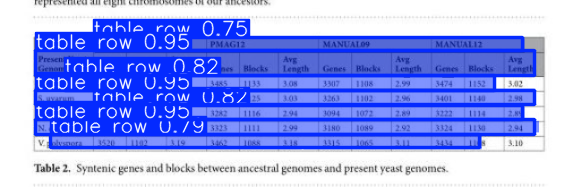

In [13]:
# Load the dataset configuration
with open(r"/kaggle/working/dataset/dataset.yaml", 'r') as file:
    dataset_config = yaml.safe_load(file)

# Get the dataset path and class names
dataset_path = dataset_config['path']
class_names = dataset_config['names']

# Choose a random set (train or val)
image_set = random.choice(['train', 'val'])
images_path = os.path.join(dataset_path, image_set, 'images')

# Get a list of all image files
image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Choose a random image
random_image = random.choice(image_files)
image_path = os.path.join(images_path, random_image)

# Run batched inference on a list of images
results = model([image_path])  # return a list of Results objects

# Process results list
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    obb = result.obb  # Oriented boxes object for OBB outputs
    result.show()  # display to screen
    result.save(filename="result.jpg")  # save to disk

# Model export

In [14]:
model.export(format="onnx", dynamic=True)

Ultralytics 8.3.39 🚀 Python-3.10.14 torch-2.4.0 CPU (Intel Xeon 2.00GHz)

PyTorch: starting from 'runs/segment/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) ((1, 37, 8400), (1, 32, 160, 160)) (43.1 MB)
requirements: Ultralytics requirements ['onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.5/291.5 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 224.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 242.2 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 19.7s, installed 2 packages: ['onnxslim', 'onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.42...
ONNX: export success ✅ 51.9s, saved as 'runs/segment/train/weights/b

'runs/segment/train/weights/best.onnx'